# Pretrained

In [1]:
import torch

In [ ]:
from torchvision import models
dir(models)

In [3]:
resnet = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 260MB/s]


In [4]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

In [7]:
!wget https://hips.hearstapps.com/hmg-prod/images/cute-photos-of-cats-lion-1593184780.jpg

--2023-09-22 13:54:54--  https://hips.hearstapps.com/hmg-prod/images/cute-photos-of-cats-lion-1593184780.jpg
Resolving hips.hearstapps.com (hips.hearstapps.com)... 151.101.0.155, 151.101.64.155, 151.101.128.155, ...
Connecting to hips.hearstapps.com (hips.hearstapps.com)|151.101.0.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355505 (347K) [image/jpeg]
Saving to: ‘cute-photos-of-cats-lion-1593184780.jpg’

cute-photos-of-cats 100%[===================>] 347.17K  --.-KB/s    in 0.009s  

2023-09-22 13:54:54 (37.6 MB/s) - ‘cute-photos-of-cats-lion-1593184780.jpg’ saved [355505/355505]



In [8]:
from PIL import Image

img = Image.open('/content/cute-photos-of-cats-lion-1593184780.jpg')

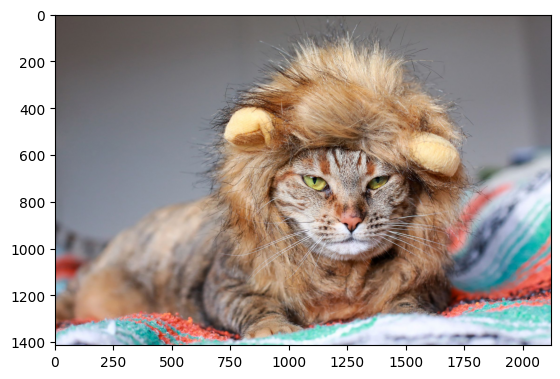

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img)

In [10]:
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)

In [16]:
print(img_t.shape)

torch.Size([3, 224, 224])


In [17]:
print(batch_t.shape)

torch.Size([1, 3, 224, 224])


In [11]:
resnet.eval()
out = resnet(batch_t)

In [12]:
torch.argmax(out)

tensor(281)

# Fine-tuning

In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision.datasets import CIFAR100

import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

In [3]:
test_transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])
])

In [4]:
train_data = CIFAR100(download=True, root='./', transform=train_transform)
test_data = CIFAR100(root='./', transform=test_transform, train=False)

100%|██████████| 169001437/169001437 [00:03<00:00, 49148097.71it/s]


Extracting ./cifar-100-python.tar.gz to ./


In [5]:
batch_size=32

train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [6]:
train_data_size = len(train_data)
test_data_size = len(test_data)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print(device)

cuda:0


In [9]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 141MB/s]


In [10]:
print(type(test_data))

<class 'torchvision.datasets.cifar.CIFAR100'>


In [11]:
ct = 0
for child in resnet50.children():
  ct += 1
  if ct < 7 :
    for param in child.parameters():
      param.requires_grad = False

In [12]:
fc_input = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_input, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 100),
    nn.LogSoftmax(dim=1)
)

resnet50 = resnet50.to(device)

In [13]:
loss_fn = nn.NLLLoss()

In [14]:
def training(model, loss_fn, optimizer, scheduler, epochs=25):
  start = time.time()
  history = []
  best_loss = 100000.0
  best_epoch = None

  for epoch in range(epochs):
    epoch_start = time.time()
    print("epoch: {}/{}".format(epoch+1, epochs))

    model.train()

    train_loss = 0.0
    train_acc = 0.0

    valid_loss = 0.0
    valid_acc = 0.0

    for i, (inputs, labels) in enumerate(train_data_loader):

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)

      loss = loss_fn(outputs, labels)
      loss.backward()

      optimizer.step()
      scheduler.step()

      train_loss += loss.item() * inputs.size(0)

      ret, pred = torch.max(outputs.data, 1)
      correct_count = pred.eq(labels.data.view_as(pred))

      acc = torch.mean(correct_count.type(torch.FloatTensor))

      train_acc += acc.item() * inputs.size(0)

    with torch.no_grad():
      model.eval()

      for j, (inputs, labels) in enumerate(test_data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)

        valid_loss += loss.item() * inputs.size(0)

        ret, pred = torch.max(outputs.data, 1)
        correct_count = pred.eq(labels.data.view_as(pred))

        acc = torch.mean(correct_count.type(torch.FloatTensor))

        valid_acc += acc.item() * inputs.size(0)

        if not j % 100:
          print(f'val batch: {j} val-loss {loss.item()} val-acc {acc.item()}')

    if valid_loss < best_loss:
      best_loss = valid_loss
      best_epoch = epoch

    avg_train_loss = train_loss/train_data_size
    avg_train_acc = train_acc/train_data_size

    avg_valid_loss = valid_loss/test_data_size
    avg_valid_acc = valid_acc/test_data_size

    history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

    epoch_end = time.time()

    print(f"Epoch {epoch+1} Train-Loss {avg_train_loss} Train-Acc {avg_train_acc*100} \n\t\t Val-Loss {avg_valid_loss} Val-acc {avg_valid_acc} Time {epoch_end - epoch_start}")


  return model, history, best_epoch


In [15]:
num_epoch = 25
optimizer = optim.Adam(resnet50.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1)
trained_model, history, best_epoch = training(resnet50, loss_fn, optimizer, scheduler, num_epoch)

epoch: 1/25
val batch: 0 val-loss 4.602168083190918 val-acc 0.03125
val batch: 100 val-loss 4.595269680023193 val-acc 0.0
val batch: 200 val-loss 4.5837225914001465 val-acc 0.0
val batch: 300 val-loss 4.5961174964904785 val-acc 0.03125
Epoch 1 Train-Loss 4.611160076293945 Train-Acc 1.008 
		 Val-Loss 4.599949168395996 Val-acc 0.0129 Time 461.4375946521759
epoch: 2/25
val batch: 0 val-loss 4.513746738433838 val-acc 0.0
val batch: 100 val-loss 4.587955951690674 val-acc 0.0
val batch: 200 val-loss 4.41503381729126 val-acc 0.0
val batch: 300 val-loss 4.423797607421875 val-acc 0.09375
Epoch 2 Train-Loss 4.594949769592285 Train-Acc 1.3679999999999999 
		 Val-Loss 4.53879840927124 Val-acc 0.0169 Time 462.2556662559509
epoch: 3/25
val batch: 0 val-loss 3.8907432556152344 val-acc 0.03125
val batch: 100 val-loss 3.640904426574707 val-acc 0.03125
val batch: 200 val-loss 4.155248641967773 val-acc 0.0
val batch: 300 val-loss 3.69089412689209 val-acc 0.09375
Epoch 3 Train-Loss 4.3346355284881595 Tra